# Popular Data Science Questions Project

We'll explore Data Science Stack Exchange's database and investigate a few of the tables, especially those whose names sound more promising, writing a few queries to get a feel for the data. 
We've selected a few columns on the posts table to help us on our goal:
Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount

# Extracting the data

We'll run a query against the SEDE DSSE database that extracts the columns listed below for all the questions in 2019.

+ SELECT Id,
* PostTypeId,
* CreationDate,
* Score,
* ViewCount,
* Tags,
* AnswerCount,
* FavoriteCount
* FROM posts
* WHERE PostTypeID = 1 AND Year(CreationDate) = 2019;


We'll import it into a dataframe and review the dataframe to understand it

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv ('2019_questions.csv', parse_dates=['CreationDate'])

print (df.head())
print (df.shape)
print (df.info())

      Id        CreationDate  Score  ViewCount  \
0  44419 2019-01-23 09:21:13      1         21   
1  44420 2019-01-23 09:34:01      0         25   
2  44423 2019-01-23 09:58:41      2       1651   
3  44427 2019-01-23 10:57:09      0         55   
4  44428 2019-01-23 11:02:15      0         19   

                                                Tags  AnswerCount  \
0                    <machine-learning><data-mining>            0   
1  <machine-learning><regression><linear-regressi...            0   
2       <python><time-series><forecast><forecasting>            0   
3              <machine-learning><scikit-learn><pca>            1   
4           <dataset><bigdata><data><speech-to-text>            0   

   FavoriteCount  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
(8839, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     

# Cleaning the data

Looking at the of each row, it stands out that FavouriteCount has missing values. No other columns shows missing values. 

It does not seem feasible to fill the FavoriteCount missing values, except to transform them to 0 and type it as int64.   

Now all columns seem to have adequate types for our analysis, except for tags columns that show multiple tags in each row.

In [2]:
df['FavoriteCount'] = df['FavoriteCount'].fillna(0).astype(int)
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB
None


We'll clean the <> symbols and create a list that we'll assign to Tags again.

In [3]:
df['Tags'] = df['Tags'].str.replace('><',',')
df['Tags'] = df['Tags'].str.replace('>','').str.replace('<','')
df['Tags'] = df['Tags'].str.split(',')
df.sample(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
6450,64089,2019-12-02 12:04:07,0,23,"[k-means, supervised-learning]",1,0
3668,60809,2019-09-26 09:23:00,0,23,"[python, data-mining, dataset, pandas, text-mi...",1,0
4786,62404,2019-10-30 10:21:59,0,18,"[python, deep-learning, cnn, convnet, pytorch]",0,0
6183,52885,2019-05-30 05:21:02,3,53,"[machine-learning, classification, scikit-lear...",1,1
7540,43972,2019-01-14 13:58:22,5,1625,"[neural-network, feature-selection, feature-sc...",1,1


# Establishing most used tags and most viewed tags

We'll count how many times a given tag was mentioned in the questions and use that as a proxy to its popularity. 
We'll also graph the results for easier visualization. 

We'll begin with most used. 

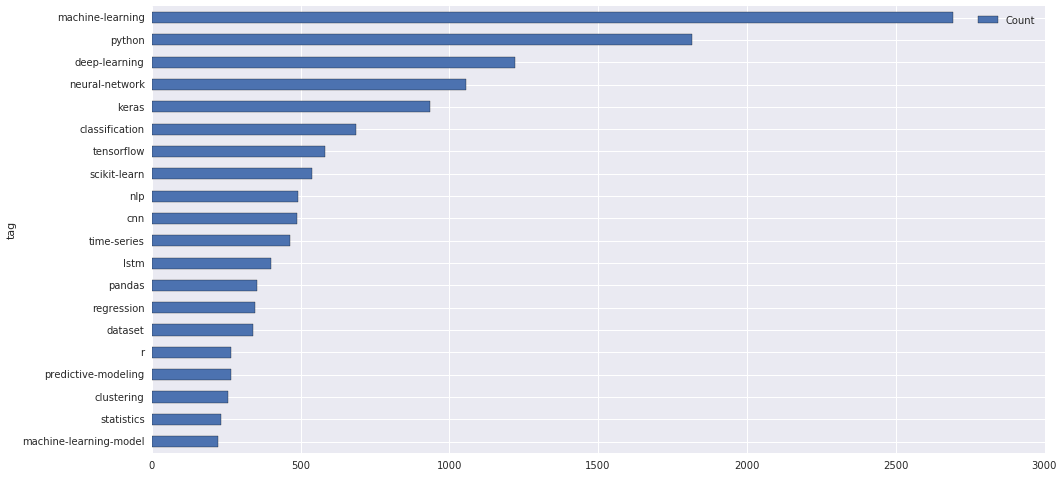

In [4]:
tags = []
for sublist in df['Tags']:
    for item in sublist:
        tags.append(item)

values, counts = np.unique(tags, return_counts=True)

d = {'Count':counts,'tag':values}

tagcount = pd.DataFrame(d, columns=['tag','Count']).sort_values(['Count'])

most_used = tagcount.sort_values(by="Count").tail(20)

most_used.plot(kind="barh", x='tag',figsize=(16,8))


Now we'll move to most viewed. 

In [5]:
##tag_view_count = dict()

##for tag in tagcount['Tags']:
##    for row in range(len(df)):
##        if tag in df.loc[row,'Tags']:
##            if tag in tag_view_count:
##                tag_view_count[tag] += df.loc[row,'ViewCount']
##            else:
##                tag_view_count[tag] = df.loc[row,'ViewCount']
##            
##tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
##tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

##most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)

##most_viewed.plot(kind="barh", figsize=(16,8))

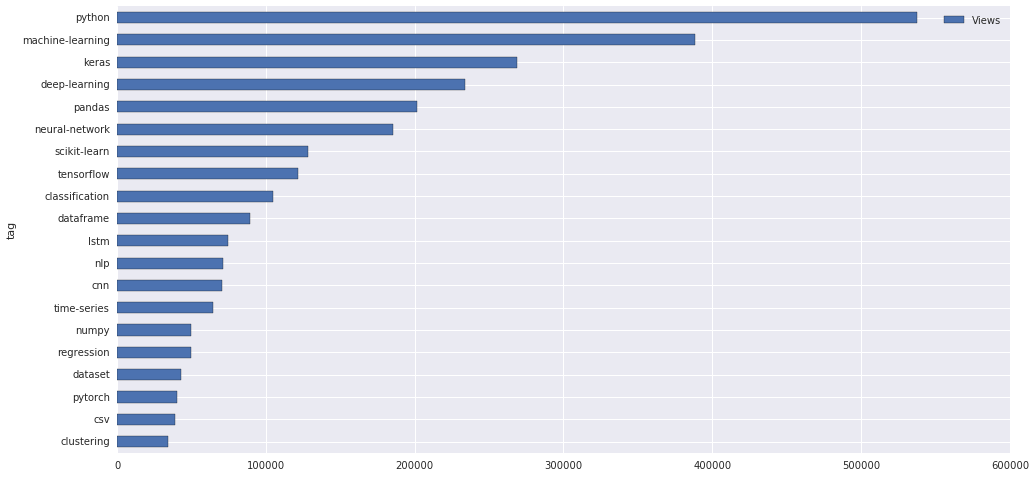

In [6]:
tag_view_count = {}

for row in range(len(df)):
    for item in df.loc[row,'Tags']:
        if item in tag_view_count:
            tag_view_count[item] += df.loc[row,'ViewCount']
        else:
            tag_view_count[item] = df.loc[row,'ViewCount']        

        
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index").reset_index()

tag_view_count.rename(columns={'index':'tag', 0:'Views'}, inplace=True)

most_viewed = tag_view_count.sort_values(by="Views").tail(20)

most_viewed.plot(kind="barh", x='tag',figsize=(16,8))

# Testing overlap of the two indicators
It will be useful indicator of popularity  to know which tags are present in both dataframes. 

In [7]:
views_in_usage_count = pd.merge(left = most_used, right = most_viewed, how = 'left', on='tag')
usage_count_in_views = pd.merge(left = most_viewed, right = most_used, how = 'left', on='tag')

In [8]:
print(views_in_usage_count.sort_values(by="Count",ascending=False))
print(usage_count_in_views.sort_values(by="Views",ascending=False))

                       tag  Count     Views
19        machine-learning   2693  388499.0
18                  python   1814  537585.0
17           deep-learning   1220  233628.0
16          neural-network   1055  185367.0
15                   keras    935  268608.0
14          classification    685  104457.0
13              tensorflow    584  121369.0
12            scikit-learn    540  128110.0
11                     nlp    493   71382.0
10                     cnn    489   70349.0
9              time-series    466   64134.0
8                     lstm    402   74458.0
7                   pandas    354  201787.0
6               regression    347   49451.0
5                  dataset    340   43151.0
4                        r    268       NaN
3      predictive-modeling    265       NaN
2               clustering    257   33928.0
1               statistics    234       NaN
0   machine-learning-model    224       NaN
                 tag   Views   Count
19            python  537585  1814.0
18

# Tags relationships

You may have noticed that the most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common: 

* python: Use for data science questions related to the programming language Python
* machine-learning:Machine Learning is a subfield of computer science that draws on elements from algorithmic analysis, computational statistics
* deep-learning:a new area of Machine Learning research concerned with the technologies used for learning hierarchical representations of data
* neural-network:Artificial neural networks (ANN), are composed of 'neurons' - programming constructs that mimic the properties of biological neurons
* keras: Keras is a popular, open-source deep learning API for Python built on top of TensorFlow and is useful for fast implementation
* tensorflow:TensorFlow is an open source library for machine learning and machine intelligence
* classification:An instance of supervised learning that identifies the category or categories which a new instance of dataset belongs
* scikit-learn:scikit-learn is a popular machine learning package for Python that has simple and efficient tools for predictive data analysis



# Digging deeper into Deep Learning:

In this we will track the interest in deep learning across time. We will:

* Count how many deep learning questions are asked per time period.
* The total amount of questions per time period.
* How many deep learning questions there are relative to the total amount of questions per time period.

In [9]:
aqdf = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])
print (aqdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
Id              21576 non-null int64
CreationDate    21576 non-null datetime64[ns]
Tags            21576 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 505.8+ KB
None


In [10]:
aqdf['Tags'] = aqdf['Tags'].str.replace('><',',')
aqdf['Tags'] = aqdf['Tags'].str.replace('>','').str.replace('<','')
aqdf['Tags'] = aqdf['Tags'].str.split(',')

aqdf.sample(5)


,Id,CreationDate,Tags
3331,2368,2014-10-29 05:25:55,"[machine-learning, time-series, feature-select..."
5473,39483,2018-10-10 17:29:43,"[neural-network, keras, convnet, computer-visi..."
6809,48475,2019-04-02 23:02:33,"[machine-learning, deep-learning, object-detec..."
7547,48723,2019-04-06 00:03:23,"[neural-network, deep-learning, gan]"
21478,36710,2018-08-09 19:15:10,"[machine-learning, python, neural-network, dee..."


In [11]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

aqdf["DeepLearning"] = aqdf["Tags"].apply(class_deep_learning)

In [12]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

aqdf = aqdf[aqdf["CreationDate"].dt.year < 2020]

aqdf["Quarter"] = aqdf["CreationDate"].apply(fetch_quarter)

In [13]:
quarterly = aqdf.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
8,16Q2,109,518,0.210425
14,17Q4,353,898,0.393096
15,18Q1,554,1221,0.453726
6,15Q4,66,382,0.172775
2,14Q4,21,216,0.097222


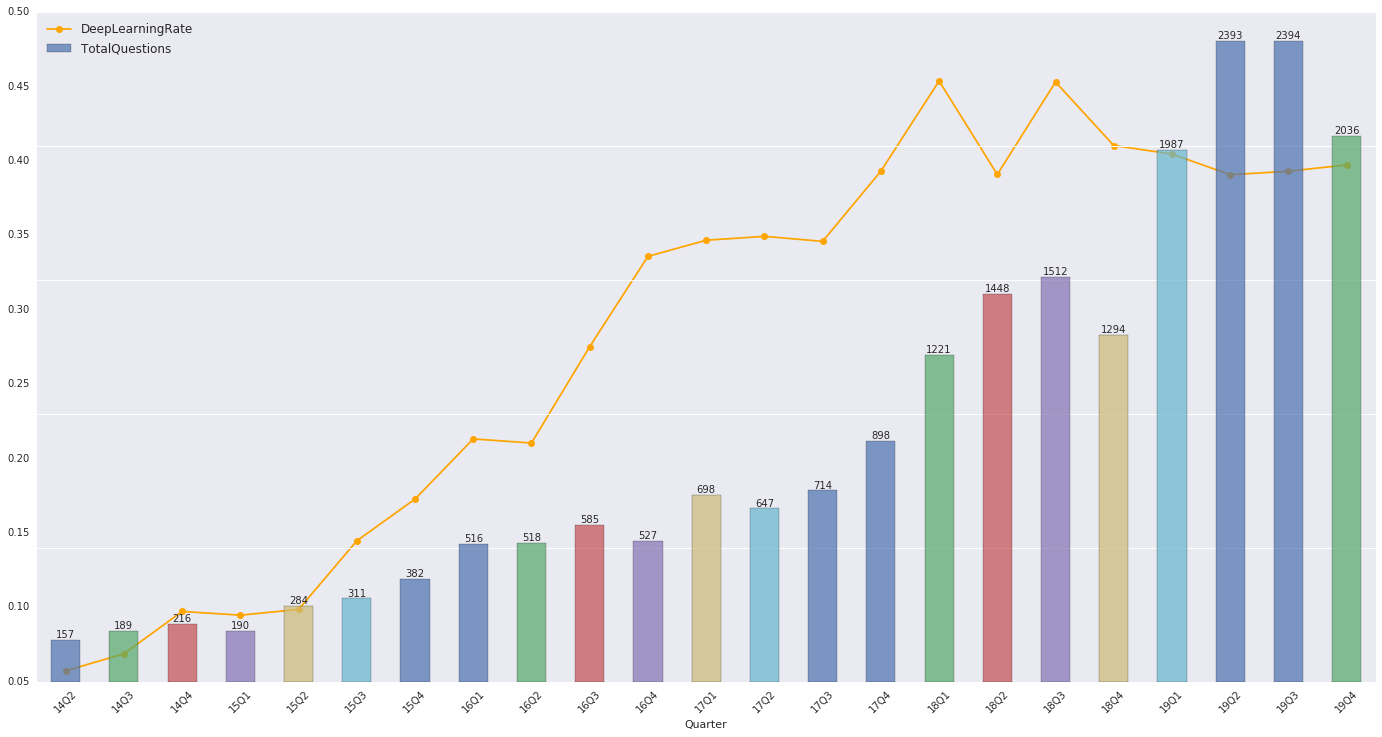

In [14]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.

# Applying same analysis to Text

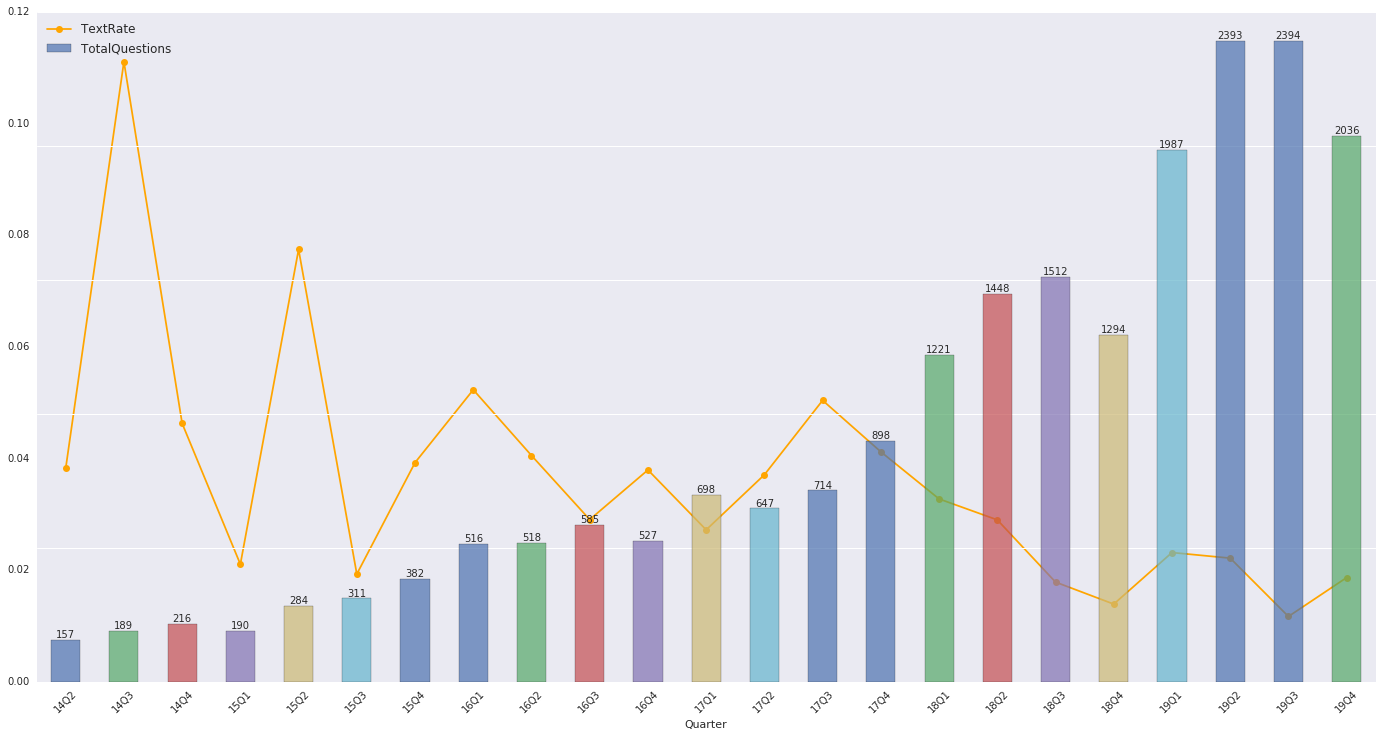

In [15]:
def class_text(tags):
    for tag in tags:
        if tag in ["text", "text-mining", "text-classification", "fasttext",
                   "text-generation", "text-filter", "text-processing"]:
            return 1
    return 0

aqdf["Text"] = aqdf["Tags"].apply(class_text)

quarterly = aqdf.groupby('Quarter').agg({"Text": ['sum', 'size']})
quarterly.columns = ['TextQuestions', 'TotalQuestions']
quarterly["TextRate"] = quarterly["TextQuestions"]\
                                /quarterly["TotalQuestions"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)

ax1 = quarterly.plot(x="Quarter", y="TextRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It seems that text related questions have decreased in interest in recent times so there is no possible proposal to explore. 